# Multiple lines from a 2d DataArray

Use xarray.plot.line() on a 2d DataArray to plot selections as multiple lines.

See Multiple lines showing variation along a dimension for more details.

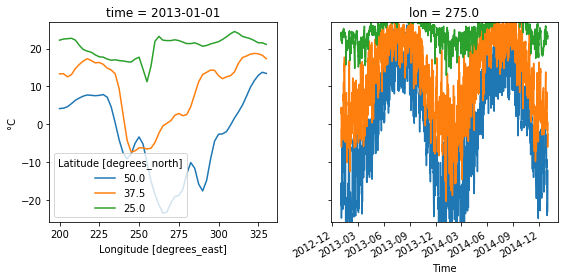

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

import xarray as xr

# Load the data
ds = xr.tutorial.load_dataset('air_temperature')
air = ds.air - 273.15  # to celsius

# Prepare the figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# Selected latitude indices
isel_lats = [10, 15, 20]

# Temperature vs longitude plot - illustrates the "hue" kwarg
air.isel(time=0, lat=isel_lats).plot.line(ax=ax1, hue='lat')
ax1.set_ylabel('°C')

# Temperature vs time plot - illustrates the "x" and "add_legend" kwargs
air.isel(lon=30, lat=isel_lats).plot.line(ax=ax2, x='time', add_legend=False)
ax2.set_ylabel('')

# Show
plt.tight_layout()
plt.show()

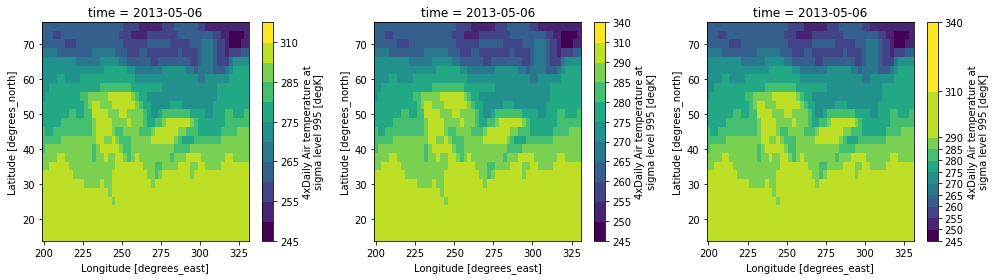

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

# Load the data
air_temp = xr.tutorial.load_dataset('air_temperature')
air2d = air_temp.air.isel(time=500)

# Prepare the figure
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

# Irregular levels to illustrate the use of a proportional colorbar
levels = [245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 310, 340]

# Plot data
air2d.plot(ax=ax1, levels=levels)
air2d.plot(ax=ax2, levels=levels, cbar_kwargs={'ticks': levels})
air2d.plot(ax=ax3, levels=levels, cbar_kwargs={'ticks': levels,
                                               'spacing': 'proportional'})

# Show plots
plt.tight_layout()
plt.show()

/home/helge/miniconda3/envs/geopython/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


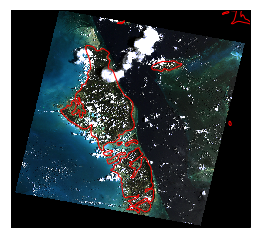

In [10]:
import os
import urllib.request

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import xarray as xr

# Download the file from rasterio's repository
url = 'https://github.com/mapbox/rasterio/raw/master/tests/data/RGB.byte.tif'
urllib.request.urlretrieve(url, 'RGB.byte.tif')

# Read the data
da = xr.open_rasterio('RGB.byte.tif')

# The data is in UTM projection. We have to set it manually until
# https://github.com/SciTools/cartopy/issues/813 is implemented
crs = ccrs.UTM('18N')

# Plot on a map
ax = plt.subplot(projection=crs)
da.plot.imshow(ax=ax, rgb='band', transform=crs)
ax.coastlines('10m', color='r')
plt.show()

# Delete the file
os.remove('RGB.byte.tif')

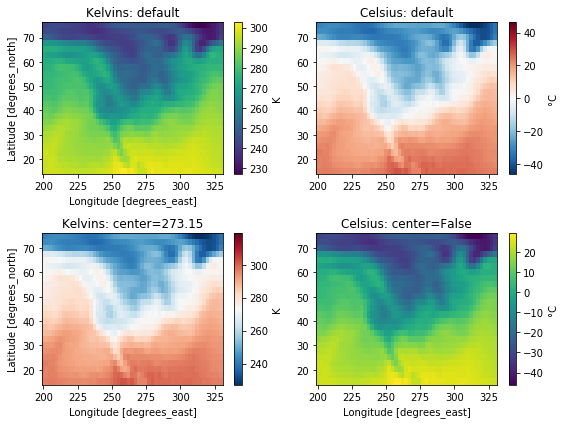

In [11]:
import matplotlib.pyplot as plt

import xarray as xr

# Load the data
ds = xr.tutorial.load_dataset('air_temperature')
air = ds.air.isel(time=0)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6))

# The first plot (in kelvins) chooses "viridis" and uses the data's min/max
air.plot(ax=ax1, cbar_kwargs={'label': 'K'})
ax1.set_title('Kelvins: default')
ax2.set_xlabel('')

# The second plot (in celsius) now chooses "BuRd" and centers min/max around 0
airc = air - 273.15
airc.plot(ax=ax2, cbar_kwargs={'label': '°C'})
ax2.set_title('Celsius: default')
ax2.set_xlabel('')
ax2.set_ylabel('')

# The center doesn't have to be 0
air.plot(ax=ax3, center=273.15, cbar_kwargs={'label': 'K'})
ax3.set_title('Kelvins: center=273.15')

# Or it can be ignored
airc.plot(ax=ax4, center=False, cbar_kwargs={'label': '°C'})
ax4.set_title('Celsius: center=False')
ax4.set_ylabel('')

# Mke it nice
plt.tight_layout()
plt.show()

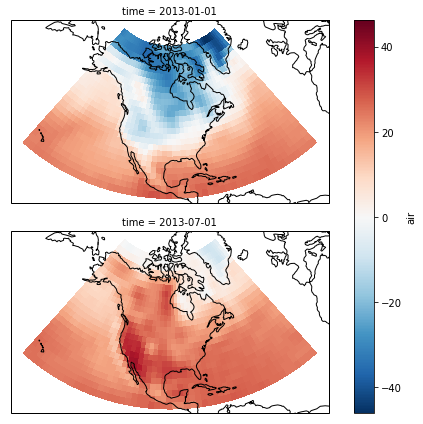

In [15]:
from __future__ import division

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import xarray as xr

# Load the data
ds = xr.tutorial.load_dataset('air_temperature')
air = ds.air.isel(time=[0, 724]) - 273.15

# This is the map projection we want to plot *onto*
map_proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)

p = air.plot(transform=ccrs.PlateCarree(),  # the data's projection
             col='time', col_wrap=1,  # multiplot settings
             aspect=ds.dims['lon'] / ds.dims['lat'],  # for a sensible figsize
             subplot_kws={'projection': map_proj})  # the plot's projection

# We have to set the map's options on all four axes
for ax in p.axes.flat:
    ax.coastlines()
    ax.set_extent([-160, -30, 5, 75])
    # Without this aspect attributes the maps will look chaotic and the
    # "extent" attribute above will be ignored
    ax.set_aspect('equal')

plt.show()

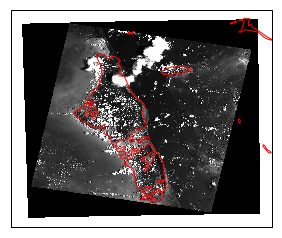

In [16]:
import os
import urllib.request

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from rasterio.warp import transform

import xarray as xr

# Download the file from rasterio's repository
url = 'https://github.com/mapbox/rasterio/raw/master/tests/data/RGB.byte.tif'
urllib.request.urlretrieve(url, 'RGB.byte.tif')

# Read the data
da = xr.open_rasterio('RGB.byte.tif')

# Compute the lon/lat coordinates with rasterio.warp.transform
ny, nx = len(da['y']), len(da['x'])
x, y = np.meshgrid(da['x'], da['y'])

# Rasterio works with 1D arrays
lon, lat = transform(da.crs, {'init': 'EPSG:4326'},
                     x.flatten(), y.flatten())
lon = np.asarray(lon).reshape((ny, nx))
lat = np.asarray(lat).reshape((ny, nx))
da.coords['lon'] = (('y', 'x'), lon)
da.coords['lat'] = (('y', 'x'), lat)

# Compute a greyscale out of the rgb image
greyscale = da.mean(dim='band')

# Plot on a map
ax = plt.subplot(projection=ccrs.PlateCarree())
greyscale.plot(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(),
               cmap='Greys_r', add_colorbar=False)
ax.coastlines('10m', color='r')
plt.show()

# Delete the file
os.remove('RGB.byte.tif')